# Comparative analysis of the 1995 and 2016 manifestos (see paper section 4.3)

__Computational Literary Studies<br>
L. Verreyen, O. van der Burgh, P. Claes__

This file contains a comparative analysis of the 1995 and 2016 manifestos. The methods of analysis applied are Principal Component Analysis (PCA), Hierarchical Agglomerative Clustering (HAC), and Variability Neighbor Clustering (VNC). The file is structured as followed:

1. Preparing the data
- 1.1. Importing packages
- 1.2. Defining functions
- 1.3. Preprocessing the data
2. Principal Component Analysis
3. Hierarchical Agglomerative Clustering
4. Variability Neighbor Clustering

## 1. Preparing the data

### 1.1. Importing packages

In [ ]:
import glob
import os

import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
import collections

import sklearn.feature_extraction.text as text
import sklearn.preprocessing as preprocessing
import sklearn.decomposition as decomposition
from sklearn.metrics import pairwise_distances

import mpl_axes_aligner.align

import scipy.spatial.distance as scidist
import scipy.cluster.hierarchy as hierarchy

from HACluster import *

### 1.2. Defining functions

In [ ]:
def load_directory(directory, max_length):
    
    """Takes directory and max_length as arguments. 
    Loads the txt-files found in the directory. 
    Segments the txt-files according to the value given for max_length.
    Returns a Pandas dataframe with three columns:
    titles, years, and documents."""
    
    documents, years, titles = [], [], []
    
    for filename in glob.glob(directory):
        with open(filename, encoding='utf-8') as f:
            contents = f.read()
        filename = os.path.basename(filename).replace('.txt', '')
        year = filename[:4]
        lemmas = contents.lower().split()
        start_idx, end_idx, segm_cnt = 0, max_length, 1
        while end_idx < len(lemmas):
            documents.append(' '.join(lemmas[start_idx:end_idx]))
            years.append(year)
            titles.append(f'{filename}_{segm_cnt}')
            start_idx += max_length
            end_idx += max_length
            segm_cnt += 1
            
    return pd.DataFrame({'titles': titles,
                         'years': years,
                         'documents': documents})

In [ ]:
PUNCT_RE = re.compile(r'[^\w\s]+$')

def is_punkt(string):
    
    """Checks if string is a punctuation marker 
    or a sequence of punctuation markers."""
    
    return PUNCT_RE.match(string) is not None

In [ ]:
def preprocess_text(text, language, lowercase=True):
    
    """Performs a text preprocessing procedure, which transforms a string
    object into a list of word tokens without punctuation markers."""
    
    if lowercase:
        text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text, language=language)
    tokens = [token for token in tokens if not is_punkt(token)]
    
    return tokens

In [ ]:
def extract_mfw(corpus, n=50):
    
    """Iterate over the tokenized texts in a corpus and extract the n most frequent words."""
    
    cnt = collections.Counter()
    for document in corpus:
        cnt.update(document)
    
    return set([w for w, c, in cnt.most_common(n)])

In [ ]:
def save_mfw(mfw, filepath='mfw.txt'):
    
    """Save an alphabetically sorted mfw list to a file for manual culling."""
    
    with open(filepath, 'w', encoding='utf8') as f:
        for w in sorted(mfw):
            f.write(w+'\n')

In [ ]:
def load_mfw(filepath='mfw_culled.txt'):
    
    """Load the mfw from a file (potentially culled using hashtags)."""
    
    mfw = set()
    for line in open(filepath, 'r'):
        line = line.strip()
        if line and not line.startswith('#'):
            mfw.add(line)
            
    return mfw

In [ ]:
def plot_pca(document_proj, loadings, var_exp, labels, title):
    
    # the texts
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, labels in zip(x1, x2, labels):
        color = 'red' if labels == '1995' else 'green'
        text_ax.text(p1, p2, labels, ha='center',
                     color=color, va='center', fontsize=12)
        
    # add variance information to the axis labels
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')

    # the loadings
    loadings_ax = text_ax.twinx().twiny() 
    l1, l2 = loadings[:, 0], loadings[:, 1]
    loadings_ax.scatter(l1, l2, facecolors='none');
    for x, y, loading in zip(l1, l2, vectorizer.get_feature_names()):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)
    
    # align the original axis with its twin
    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0)
    
    # add title
    plt.title(title);

In [ ]:
def plot_tree(linkage_object, labels, figsize=(10, 80), ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        tree = hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=0, orientation = "left")
        
    # remove ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)
    
    for leaf, label in zip(ax.get_ymajorticklabels(), tree['ivl']):
        if '1995' in label:
            leaf.set_color('red')
        else: 
            leaf.set_color('green')

In [ ]:
def vnc(documents, labels):
    
    dm = pairwise_distances(documents)
    clusterer = VNClusterer(dm)
    clusterer.cluster()
    t = clusterer.dendrogram.ete_tree(labels=labels)
    
    return t.render("%%inline", h=100, w=50, units='in')

### 1.3. Preprocessing the data

In [ ]:
# load directory and segment txt-files

df = load_directory('C:/Users/Lenovo/Desktop/CLS/final_project_corrected/data/manifestos/*.txt', max_length=1500)
df.sample(5)

,titles,years,documents
0,1995_manifesto_1,1995,the unabomber manifesto1 industrial society an...
36,2010_manifesto_15,2010,"a unitary, monolithic organization, or it may ..."
55,2016_manifesto_14,2016,all the extinctions that occurred at the end o...
85,2016_manifesto_44,2016,by pointing out that similar evils inevitably ...
70,2016_manifesto_29,2016,"require. in other words, the movement must mai..."


In [ ]:
# select 1995 and 2016 manifestos

df = df[df['years'].isin(['1995', '2016'])]
df.sample(5)

,titles,years,documents
75,2016_manifesto_34,2016,merely a collective propagandist and collectiv...
3,1995_manifesto_4,1995,to pursue. scientific work may be motivated in...
84,2016_manifesto_43,2016,act in ways that serve the organizations that ...
80,2016_manifesto_39,2016,"in relation to constitutional rights, he has n..."
0,1995_manifesto_1,1995,the unabomber manifesto1 industrial society an...


In [ ]:
# titles, years, and documents to lists

titles = df['titles'].tolist()
years = df['years'].tolist()
documents = df['documents'].tolist()

In [ ]:
# preprocess documents

preprocessed_documents = [preprocess_text(document, 'english') for document in documents]

In [ ]:
# extract most frequent words

mfw = extract_mfw(preprocessed_documents, n=300)

In [ ]:
# save most frequent words

save_mfw(mfw)

In [ ]:
# load most frequent words after manually culling

mfw = load_mfw(filepath='mfw/mfw_culled_1995_2016.txt')

In [ ]:
# join tokens

preprocessed_documents = [' '.join(map(str, l)) for l in preprocessed_documents]

In [ ]:
# bag of words

vectorizer = text.CountVectorizer(vocabulary=mfw, token_pattern=r'(?u)\b\w+\b')
vectorized_documents = vectorizer.fit_transform(preprocessed_documents).toarray()

vectorized_documents.shape

(66, 140)

In [ ]:
# normalize documents

normalized_documents = preprocessing.normalize(vectorized_documents.astype(float), norm='l1')

## 2. Principal Component Analysis

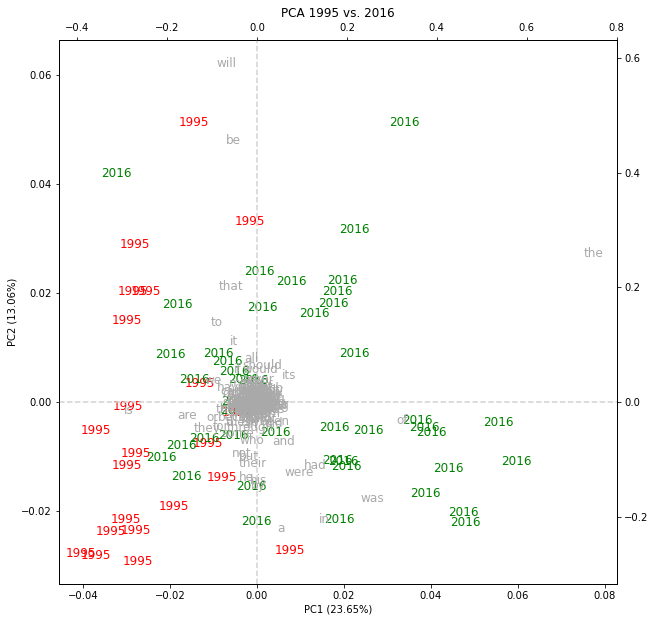

In [ ]:
# fit pca

pca = decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(normalized_documents)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, years, title='PCA 1995 vs. 2016')

In [ ]:
# coordinates and years to dataframe

x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
df_coordinates = pd.DataFrame({'x1': x1,
                               'x2': x2,
                               'years': years})
df_coordinates.head()

,x1,x2,years
0,-0.036960,-0.005317,1995
1,-0.030146,-0.021547,1995
2,-0.033551,-0.023705,1995
3,-0.011245,-0.007672,1995
4,-0.019030,-0.019137,1995


In [ ]:
# save csv

df_coordinates.to_csv('pca_df_coordinates_1995_2016.csv')

# for statistical analysis see file 'statistical_analysis.ipynb'

## 3. Hierarchical Agglomerative Clustering

In [ ]:
# calculate pairwise distances

dm = scidist.pdist(normalized_documents, 'cityblock')

In [ ]:
# establish branch structure

linkage_object = hierarchy.linkage(dm, method='complete')

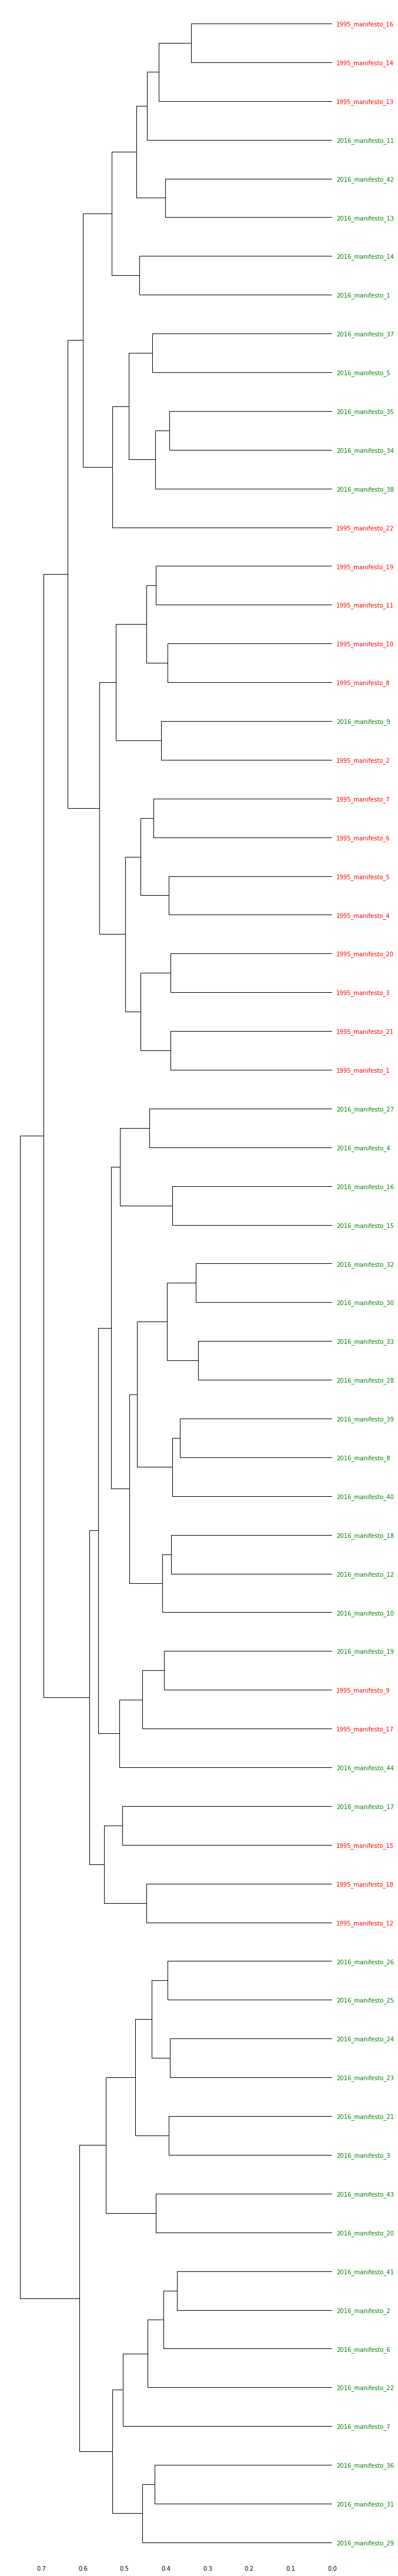

In [ ]:
# plot tree

plot_tree(linkage_object, titles)

## 4. Variability Neighbor Clustering 

In [ ]:
# TF-IDF vectorization

vectorizer = text.TfidfVectorizer(vocabulary=mfw, token_pattern=r'(?u)\b\w+\b')
vectorized_documents = vectorizer.fit_transform(preprocessed_documents).toarray()

vectorized_documents.shape

(66, 140)

In [ ]:
# normalize documents

normalized_documents = preprocessing.normalize(vectorized_documents.astype(float), norm='l1')

In [ ]:
# define labels

labels = [df['titles'][value] for value in df['documents'].index]

C:\Users\Lenovo\anaconda3\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Lenovo\anaconda3\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


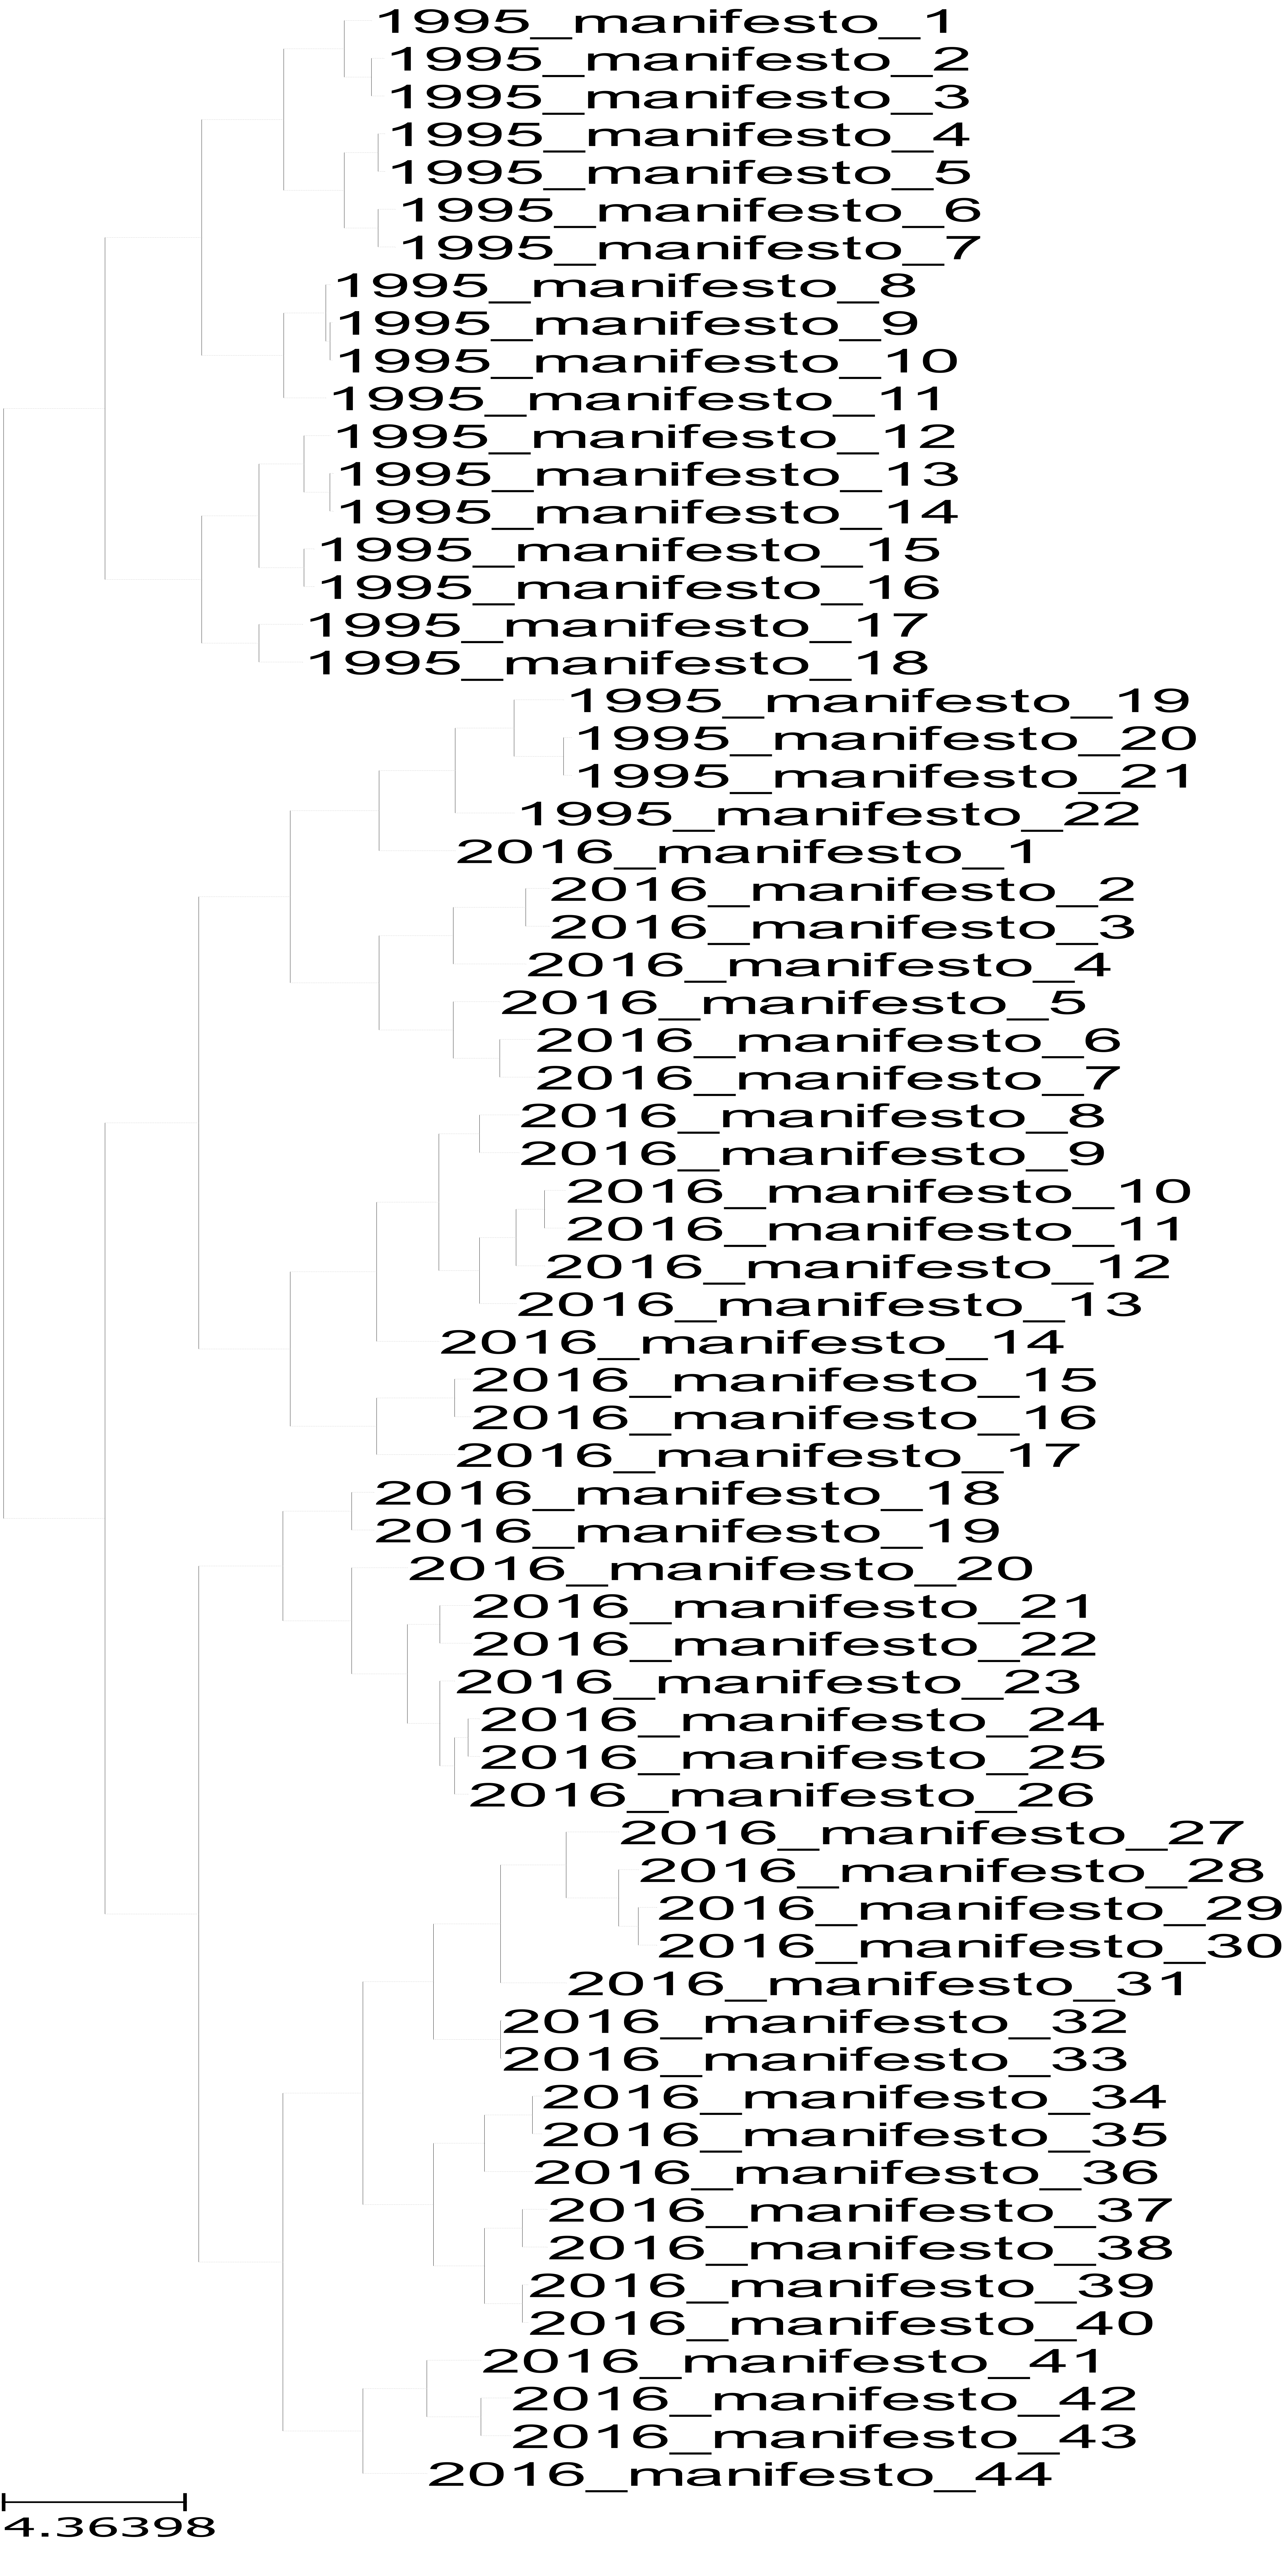

In [ ]:
# plot tree

vnc(normalized_documents, labels)